# Prysm RLNC Block Arrivals Analysis

This notebook analyzes the impact of Reed-Solomon Linear Network Coding (RLNC) implementation by Prysm on beacon block propagation times. We compare block arrival times between NFT-Devnet-2 (before RLNC) and NFT-Devnet-3 (after RLNC).

In [1]:
# Import necessary packages
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from sqlalchemy import create_engine, text
from datetime import datetime, timedelta

# Add scripts directory to path
sys.path.append('./scripts')

# Import custom modules
from bootstrap import load_env, create_db_url, add_branding, process_config
from clickhouse import ClickhouseClient
from transforms import process_block_data, process_blob_data, calculate_arrival_metrics, compare_networks

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

/Users/samcm/.pyenv/versions/anaconda3-2022.05/envs/ldm/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Configuration
config = {
    "before": {
        "network": "nft-devnet-2",
        "start_at_slot": 0,
        "finish_at_slot": 2000
    },
    "after": {
        "network": "nft-devnet-3",
        "start_at_slot": 0,
        "finish_at_slot": 2000
    }
}

# Validate and process the config
config = process_config(config)

# Load environment variables
credentials = load_env()
db_url = create_db_url(credentials)

# Initialize Clickhouse client
clickhouse = ClickhouseClient(db_url)

## Data Collection

Let's collect block arrival data from both networks.

In [3]:
# Fetch data for the "before" network (NFT-Devnet-2)
print(f"Fetching data for {config['before']['network']} (before RLNC)...")

before_block_data = clickhouse.fetch_block_arrival_times(
    config['before']['network'], 
    config['before']['start_at_slot'], 
    config['before']['finish_at_slot']
)

before_head_data = clickhouse.fetch_head_arrival_times(
    config['before']['network'], 
    config['before']['start_at_slot'], 
    config['before']['finish_at_slot']
)

before_blob_data = clickhouse.fetch_blob_data(
    config['before']['network'], 
    config['before']['start_at_slot'], 
    config['before']['finish_at_slot']
)

# Fetch data for the "after" network (NFT-Devnet-3)
print(f"Fetching data for {config['after']['network']} (after RLNC)...")

after_block_data = clickhouse.fetch_block_arrival_times(
    config['after']['network'], 
    config['after']['start_at_slot'], 
    config['after']['finish_at_slot']
)

after_head_data = clickhouse.fetch_head_arrival_times(
    config['after']['network'], 
    config['after']['start_at_slot'], 
    config['after']['finish_at_slot']
)

after_blob_data = clickhouse.fetch_blob_data(
    config['after']['network'], 
    config['after']['start_at_slot'], 
    config['after']['finish_at_slot']
)

Fetching data for nft-devnet-2 (before RLNC)...
Fetching data for nft-devnet-3 (after RLNC)...


## Data Processing

Now let's process the data to calculate metrics for both networks.

In [4]:
# Process data for before network
before_combined = process_block_data(
    before_block_data, 
    before_head_data
)

before_blobs = process_blob_data(before_blob_data)
before_metrics = calculate_arrival_metrics(before_combined, before_blobs)

# Process data for after network
after_combined = process_block_data(
    after_block_data, 
    after_head_data
)

after_blobs = process_blob_data(after_blob_data)
after_metrics = calculate_arrival_metrics(after_combined, after_blobs)

# Add network label for visualization
before_metrics['network'] = 'before_rlnc'
after_metrics['network'] = 'after_rlnc'

# Combine for easier comparison
all_metrics = pd.concat([before_metrics, after_metrics], ignore_index=True)

# Show summary statistics
print("Dataset summary:")
print(f"Before RLNC ({config['before']['network']}): {len(before_metrics)} slots, {before_combined['meta_client_name'].nunique()} unique clients")
print(f"After RLNC ({config['after']['network']}): {len(after_metrics)} slots, {after_combined['meta_client_name'].nunique()} unique clients")

# Compare the networks
comparison = compare_networks(before_metrics, after_metrics)

# Show improvement for key metrics
print("\nOverall improvement in arrival times:")
for metric in ['min_arrival_time', 'p50_arrival_time', 'p95_arrival_time']:
    before_avg = comparison[metric]['before']
    after_avg = comparison[metric]['after']
    diff = comparison[metric]['difference']
    pct = comparison[metric]['improvement_percent']
    
    print(f"{metric.replace('_arrival_time', '')}: {before_avg:.1f}ms → {after_avg:.1f}ms ({diff:.1f}ms improvement, {pct:.1f}%)")

Dataset summary:
Before RLNC (nft-devnet-2): 270 slots, 146 unique clients
After RLNC (nft-devnet-3): 0 slots, 0 unique clients

Overall improvement in arrival times:
min: 2442.8ms → nanms (nanms improvement, nan%)
p50: 2822.2ms → nanms (nanms improvement, nan%)
p95: 3091.4ms → nanms (nanms improvement, nan%)


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_7717/2574154737.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_metrics = pd.concat([before_metrics, after_metrics], ignore_index=True)


## Visualization: Overall Block Arrival Time Comparison

Let's create visualizations to compare the networks.

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_7717/593266323.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_7717/593266323.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'Before RLNC\n({config["before"]["network"]})',
posx and posy should be finite values
posx and posy should be finite values
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_7717/593266323.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


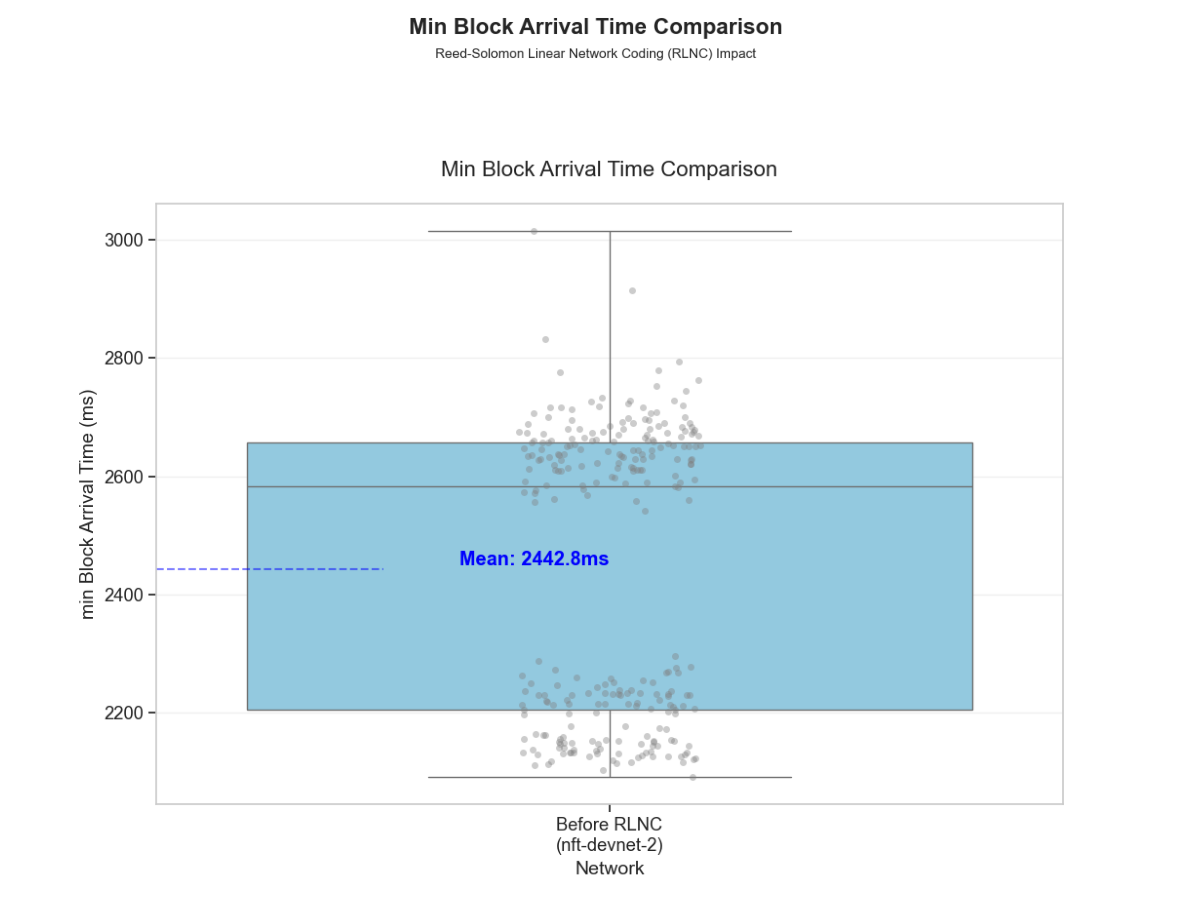

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_7717/593266323.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_7717/593266323.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'Before RLNC\n({config["before"]["network"]})',
posx and posy should be finite values
posx and posy should be finite values
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_7717/593266323.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


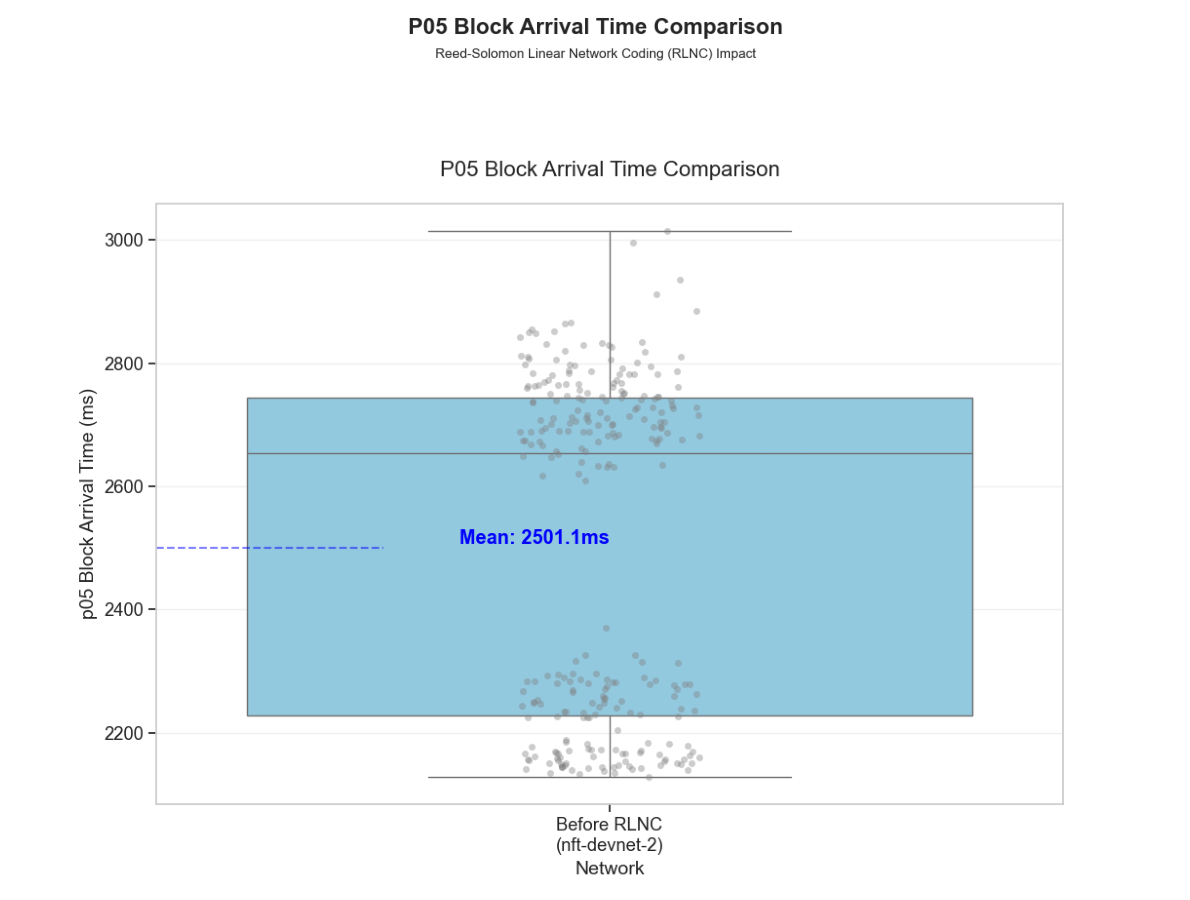

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_7717/593266323.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_7717/593266323.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'Before RLNC\n({config["before"]["network"]})',
posx and posy should be finite values
posx and posy should be finite values
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_7717/593266323.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


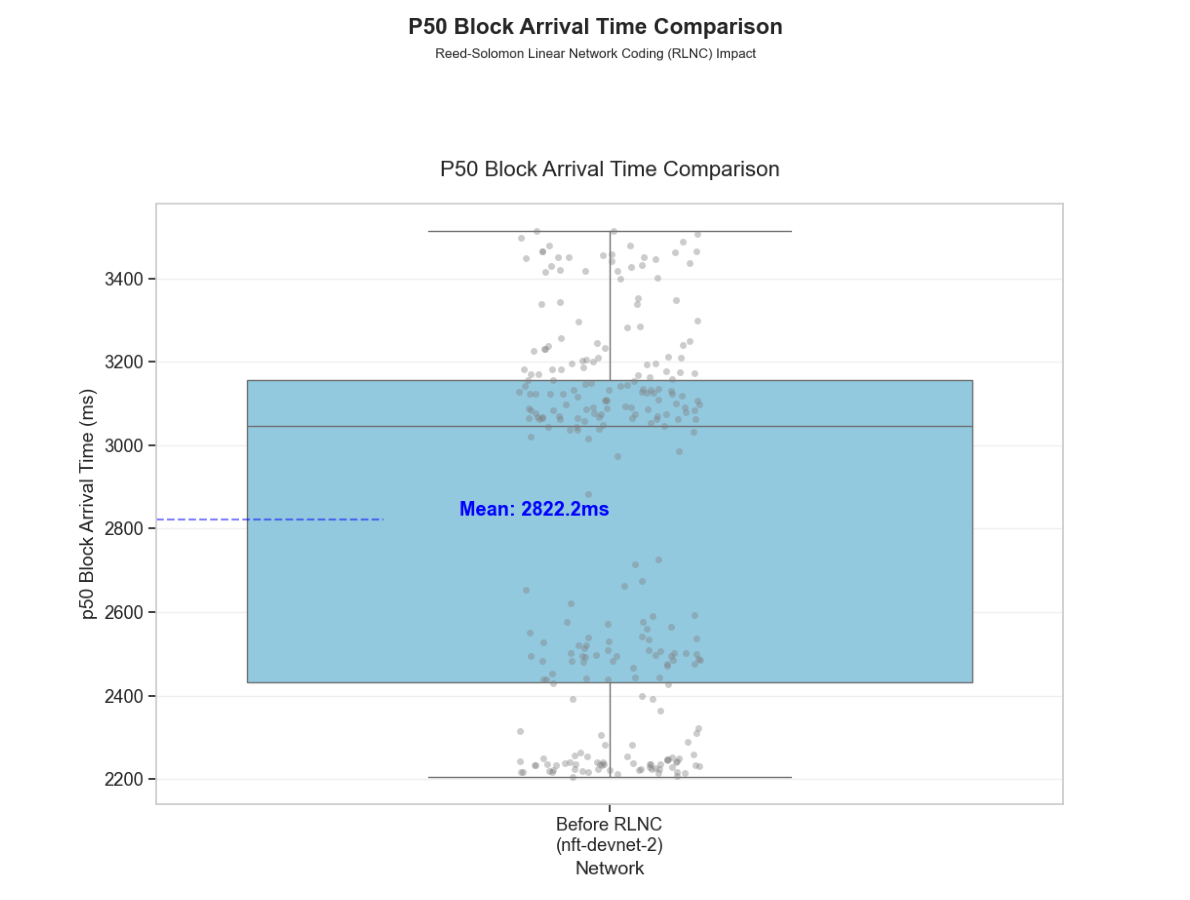

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_7717/593266323.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_7717/593266323.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'Before RLNC\n({config["before"]["network"]})',
posx and posy should be finite values
posx and posy should be finite values
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_7717/593266323.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


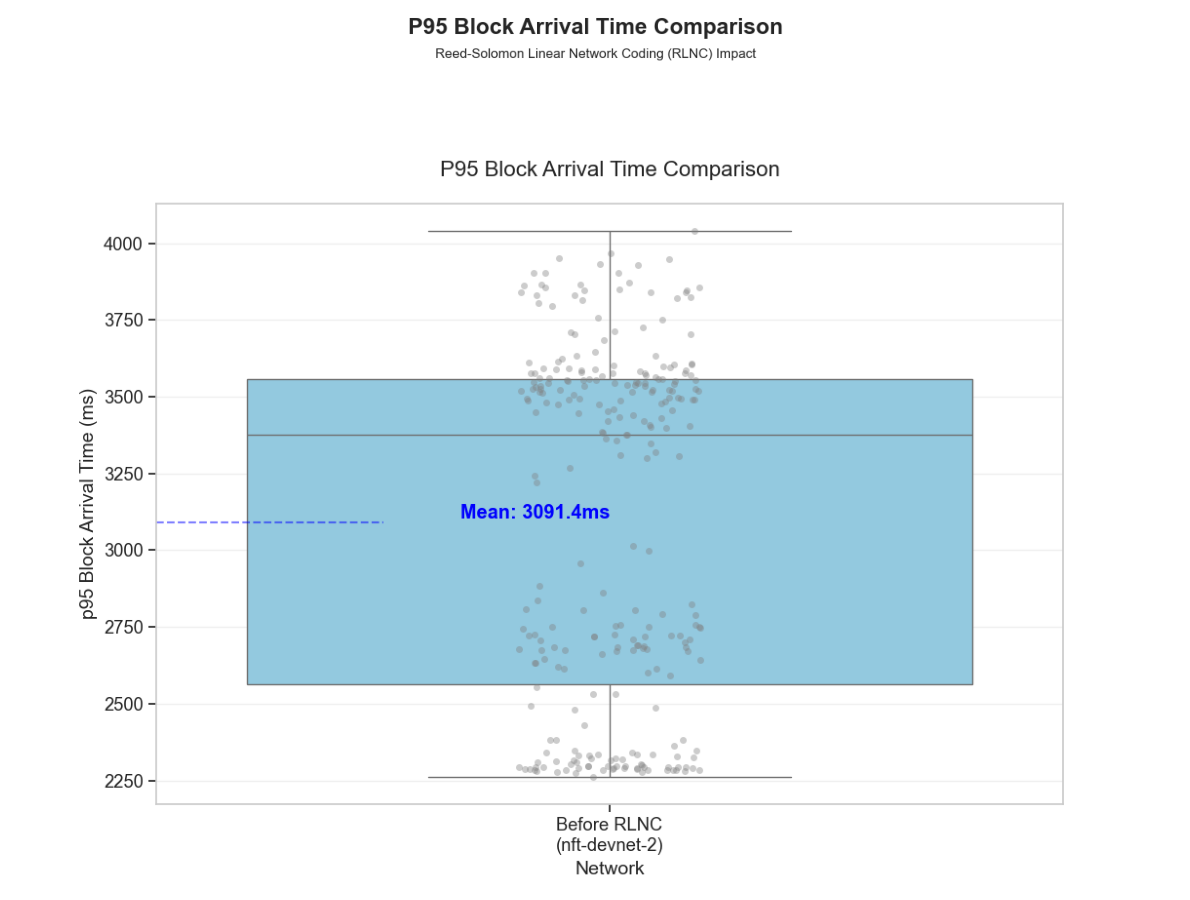

In [5]:
def create_boxplot(metrics_df, metric='p50_arrival_time', title=None, subtitle=None):
    """
    Create a box plot comparing before and after networks for a specified metric.
    
    Args:
        metrics_df (DataFrame): Combined metrics from both networks
        metric (str): The metric to plot
        title (str, optional): Title for the plot
        subtitle (str, optional): Subtitle for the plot
        
    Returns:
        matplotlib.figure.Figure: The figure with the plot
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create box plot
    sns.boxplot(
        x='network', 
        y=metric, 
        data=metrics_df,
        palette={'before_rlnc': 'skyblue', 'after_rlnc': 'lightgreen'},
        ax=ax
    )
    
    # Add individual data points
    sns.stripplot(
        x='network', 
        y=metric, 
        data=metrics_df,
        color='gray',
        alpha=0.4,
        jitter=True,
        ax=ax
    )
    
    # Set axis labels and title
    ax.set_xlabel('Network', fontsize=14)
    ax.set_ylabel(f'{metric.replace("_arrival_time", "")} Block Arrival Time (ms)', fontsize=14)
    
    if title:
        ax.set_title(title, fontsize=16, pad=20)
    
    # Set x-axis labels
    ax.set_xticklabels([f'Before RLNC\n({config["before"]["network"]})', 
                         f'After RLNC\n({config["after"]["network"]})']
                      )
    
    # Add grid for readability
    ax.grid(True, axis='y', alpha=0.3)
    
    # Add average line
    before_avg = metrics_df[metrics_df['network'] == 'before_rlnc'][metric].mean()
    after_avg = metrics_df[metrics_df['network'] == 'after_rlnc'][metric].mean()
    
    ax.axhline(before_avg, color='blue', linestyle='--', alpha=0.5, xmin=0, xmax=0.25)
    ax.axhline(after_avg, color='green', linestyle='--', alpha=0.5, xmin=0.75, xmax=1)
    
    # Add text for averages
    ax.text(0, before_avg, f'Mean: {before_avg:.1f}ms', 
            ha='right', va='bottom', color='blue', fontweight='bold')
    ax.text(1, after_avg, f'Mean: {after_avg:.1f}ms', 
            ha='left', va='bottom', color='green', fontweight='bold')
    
    # Add improvement percentage
    if before_avg > 0:
        improvement_pct = (before_avg - after_avg) / before_avg * 100
        improvement_text = f'Improvement: {improvement_pct:.1f}%'
        ax.text(0.5, (before_avg + after_avg) / 2, improvement_text,
                ha='center', va='center', fontsize=14, fontweight='bold',
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    # Add branding if title and subtitle are provided
    if title and subtitle:
        fig = add_branding(fig, title, subtitle)
    
    return fig

# Create box plots for different metrics
metrics_to_plot = ['min_arrival_time', 'p05_arrival_time', 'p50_arrival_time', 'p95_arrival_time']
for metric in metrics_to_plot:
    title = f"{metric.replace('_arrival_time', '').title()} Block Arrival Time Comparison"
    subtitle = "Reed-Solomon Linear Network Coding (RLNC) Impact"
    
    fig = create_boxplot(all_metrics, metric, title, subtitle)
    plt.tight_layout()
    plt.show()

## Visualization: Time Series Analysis

Let's plot the arrival times over time to see any patterns.

In [6]:
def create_timeseries_plot(before_metrics, after_metrics, metric='p50_arrival_time', window=100):
    """
    Create a time series plot with rolling average for both networks.
    
    Args:
        before_metrics (DataFrame): Metrics for the before network
        after_metrics (DataFrame): Metrics for the after network
        metric (str): The metric to plot
        window (int): Window size for rolling average
        
    Returns:
        plotly.graph_objects.Figure: The plotly figure
    """
    # Sort by slot
    before_metrics = before_metrics.sort_values('slot')
    after_metrics = after_metrics.sort_values('slot')
    
    # Calculate rolling averages
    before_metrics['rolling_avg'] = before_metrics[metric].rolling(window=window, min_periods=1).mean()
    after_metrics['rolling_avg'] = after_metrics[metric].rolling(window=window, min_periods=1).mean()
    
    # Create figure
    fig = go.Figure()
    
    # Add scatter plots for raw data
    fig.add_trace(go.Scatter(
        x=before_metrics['slot'],
        y=before_metrics[metric],
        mode='markers',
        name=f'Before RLNC ({config["before"]["network"]})',
        marker=dict(color='royalblue', size=5, opacity=0.5),
        hovertemplate='Slot: %{x}<br>Arrival Time: %{y:.1f}ms'
    ))
    
    fig.add_trace(go.Scatter(
        x=after_metrics['slot'],
        y=after_metrics[metric],
        mode='markers',
        name=f'After RLNC ({config["after"]["network"]})',
        marker=dict(color='green', size=5, opacity=0.5),
        hovertemplate='Slot: %{x}<br>Arrival Time: %{y:.1f}ms'
    ))
    
    # Add rolling average lines
    fig.add_trace(go.Scatter(
        x=before_metrics['slot'],
        y=before_metrics['rolling_avg'],
        mode='lines',
        name=f'Before RLNC Rolling Avg ({window} slots)',
        line=dict(color='navy', width=3),
        hovertemplate='Slot: %{x}<br>Rolling Avg: %{y:.1f}ms'
    ))
    
    fig.add_trace(go.Scatter(
        x=after_metrics['slot'],
        y=after_metrics['rolling_avg'],
        mode='lines',
        name=f'After RLNC Rolling Avg ({window} slots)',
        line=dict(color='darkgreen', width=3),
        hovertemplate='Slot: %{x}<br>Rolling Avg: %{y:.1f}ms'
    ))
    
    # Add horizontal lines for overall averages
    before_avg = before_metrics[metric].mean()
    after_avg = after_metrics[metric].mean()
    
    fig.add_trace(go.Scatter(
        x=[before_metrics['slot'].min(), before_metrics['slot'].max()],
        y=[before_avg, before_avg],
        mode='lines',
        name=f'Before RLNC Average: {before_avg:.1f}ms',
        line=dict(color='navy', width=2, dash='dash'),
        hoverinfo='name'
    ))
    
    fig.add_trace(go.Scatter(
        x=[after_metrics['slot'].min(), after_metrics['slot'].max()],
        y=[after_avg, after_avg],
        mode='lines',
        name=f'After RLNC Average: {after_avg:.1f}ms',
        line=dict(color='darkgreen', width=2, dash='dash'),
        hoverinfo='name'
    ))
    
    # Update layout
    fig.update_layout(
        title={
            'text': f"{metric.replace('_arrival_time', '').title()} Block Arrival Time Over Time",
            'y': 0.95,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=20)
        },
        xaxis_title="Slot Number",
        yaxis_title="Arrival Time (ms)",
        legend=dict(x=0.01, y=0.99, bgcolor='rgba(255,255,255,0.8)'),
        hovermode='closest',
        plot_bgcolor='white',
        height=600,
        width=1000
    )
    
    # Add improvement annotation
    if before_avg > 0:
        improvement_pct = (before_avg - after_avg) / before_avg * 100
        fig.add_annotation(
            x=0.5,
            y=1.05,
            xref="paper",
            yref="paper",
            text=f"Overall Improvement: {improvement_pct:.1f}%",
            showarrow=False,
            font=dict(size=16, color="black"),
            bgcolor="rgba(255,255,255,0.8)",
            bordercolor="rgba(0,0,0,0.5)",
            borderwidth=1,
            borderpad=4
        )
    
    return fig

# Create time series plots for different metrics
for metric in metrics_to_plot:
    fig = create_timeseries_plot(before_metrics, after_metrics, metric)
    fig.show()

## Analysis by Blob Count

Let's analyze how the number of blobs affects the arrival time improvements.

In [7]:
def create_blob_count_comparison(before_metrics, after_metrics, metric='p50_arrival_time'):
    """
    Create a comparison of arrival times grouped by blob count.
    
    Args:
        before_metrics (DataFrame): Metrics for the before network
        after_metrics (DataFrame): Metrics for the after network
        metric (str): The metric to plot
        
    Returns:
        plotly.graph_objects.Figure: The plotly figure
    """
    # Group by blob count
    before_by_blob = before_metrics.groupby('blob_count').agg({
        metric: ['mean', 'std', 'count'],
    }).reset_index()
    
    before_by_blob.columns = ['blob_count', 'mean', 'std', 'count']
    
    after_by_blob = after_metrics.groupby('blob_count').agg({
        metric: ['mean', 'std', 'count'],
    }).reset_index()
    
    after_by_blob.columns = ['blob_count', 'mean', 'std', 'count']
    
    # Merge the dataframes
    merged = pd.merge(before_by_blob, after_by_blob, on='blob_count', how='outer', suffixes=('_before', '_after'))
    
    # Calculate improvement
    merged['improvement'] = merged['mean_before'] - merged['mean_after']
    merged['improvement_pct'] = (merged['mean_before'] - merged['mean_after']) / merged['mean_before'] * 100
    
    # Create figure with subplots
    fig = make_subplots(rows=2, cols=1, 
                         subplot_titles=(
                             f"{metric.replace('_arrival_time', '').title()} Arrival Time by Blob Count",
                             "Improvement Percentage by Blob Count"
                         ),
                         row_heights=[0.6, 0.4],
                         vertical_spacing=0.1)
    
    # Add bar chart for mean arrival times
    fig.add_trace(
        go.Bar(
            x=merged['blob_count'],
            y=merged['mean_before'],
            name=f'Before RLNC ({config["before"]["network"]})',
            error_y=dict(type='data', array=merged['std_before'], visible=True),
            marker_color='royalblue',
            text=merged['count_before'],
            hovertemplate='Blob Count: %{x}<br>Arrival Time: %{y:.1f}ms<br>Sample Size: %{text}'
        ),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Bar(
            x=merged['blob_count'],
            y=merged['mean_after'],
            name=f'After RLNC ({config["after"]["network"]})',
            error_y=dict(type='data', array=merged['std_after'], visible=True),
            marker_color='green',
            text=merged['count_after'],
            hovertemplate='Blob Count: %{x}<br>Arrival Time: %{y:.1f}ms<br>Sample Size: %{text}'
        ),
        row=1, col=1
    )
    
    # Add improvement percentage as line chart in second subplot
    fig.add_trace(
        go.Bar(
            x=merged['blob_count'],
            y=merged['improvement_pct'],
            name='Improvement %',
            marker_color=['green' if x > 0 else 'red' for x in merged['improvement_pct']],
            text=[f"{x:.1f}%" for x in merged['improvement_pct']],
            textposition='auto',
            hovertemplate='Blob Count: %{x}<br>Improvement: %{y:.1f}%'
        ),
        row=2, col=1
    )
    
    # Add zero line to second subplot
    fig.add_shape(
        type="line",
        x0=-0.5,
        y0=0,
        x1=merged['blob_count'].max() + 0.5,
        y1=0,
        line=dict(color="black", width=1, dash="dash"),
        row=2, col=1
    )
    
    # Update layout
    fig.update_layout(
        title_text=f"Impact of RLNC on {metric.replace('_arrival_time', '').title()} Arrival Time by Blob Count",
        xaxis=dict(title="Blob Count"),
        xaxis2=dict(title="Blob Count"),
        yaxis=dict(title="Arrival Time (ms)"),
        yaxis2=dict(title="Improvement (%)"),
        legend=dict(x=0.01, y=0.99, bgcolor='rgba(255,255,255,0.8)'),
        barmode='group',
        height=800,
        width=1000,
        plot_bgcolor='white'
    )
    
    return fig

# Create blob count comparison plots for different metrics
for metric in metrics_to_plot:
    fig = create_blob_count_comparison(before_metrics, after_metrics, metric)
    fig.show()

## Percentile Analysis

Let's analyze the impact on different percentiles of arrival times.

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_7717/3432500465.py:83: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



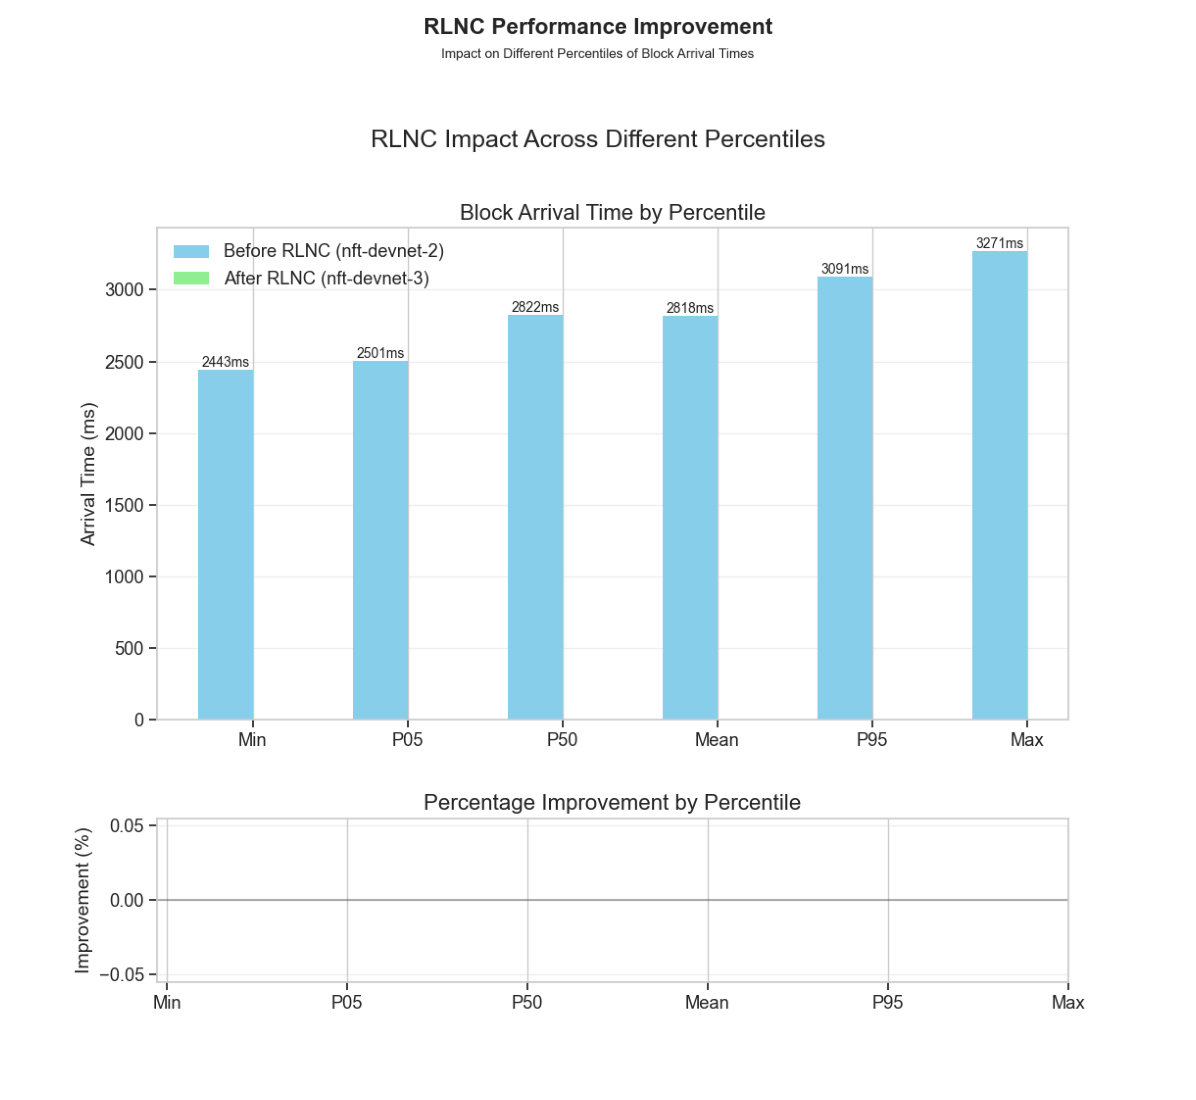

In [8]:
def create_percentile_comparison():
    """
    Create a comparison of arrival times at different percentiles.
    
    Returns:
        matplotlib.figure.Figure: The figure with the plot
    """
    # Define percentiles to compare
    metrics = [
        'min_arrival_time', 'p05_arrival_time', 
        'p50_arrival_time', 'mean_arrival_time', 
        'p95_arrival_time', 'max_arrival_time'
    ]
    
    # Get average values for each percentile
    before_values = [before_metrics[m].mean() for m in metrics]
    after_values = [after_metrics[m].mean() for m in metrics]
    
    # Calculate improvements
    improvements = [(b - a) / b * 100 if b > 0 else 0 for b, a in zip(before_values, after_values)]
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[3, 1], gridspec_kw={'hspace': 0.3})
    
    # Shortened labels for x-axis
    labels = ['Min', 'P05', 'P50', 'Mean', 'P95', 'Max']
    x = np.arange(len(labels))
    width = 0.35
    
    # Plot bars for arrival times
    rects1 = ax1.bar(x - width/2, before_values, width, label=f'Before RLNC ({config["before"]["network"]})', color='skyblue')
    rects2 = ax1.bar(x + width/2, after_values, width, label=f'After RLNC ({config["after"]["network"]})', color='lightgreen')
    
    # Add value labels
    def add_labels(rects, values):
        for rect, val in zip(rects, values):
            height = rect.get_height()
            ax1.text(rect.get_x() + rect.get_width()/2., height,
                    f'{val:.0f}ms',
                    ha='center', va='bottom', fontsize=10, rotation=0)
    
    add_labels(rects1, before_values)
    add_labels(rects2, after_values)
    
    # Set up first subplot
    ax1.set_ylabel('Arrival Time (ms)', fontsize=14)
    ax1.set_title('Block Arrival Time by Percentile', fontsize=16)
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels)
    ax1.legend()
    ax1.grid(True, axis='y', alpha=0.3)
    
    # Plot improvement percentages in second subplot
    bars = ax2.bar(x, improvements, width, color=['green' if i > 0 else 'red' for i in improvements])
    
    # Add value labels
    for bar, improvement in zip(bars, improvements):
        height = bar.get_height()
        y_pos = height + 1 if height > 0 else height - 5
        ax2.text(bar.get_x() + bar.get_width()/2., y_pos,
                f'{improvement:.1f}%',
                ha='center', va='bottom' if height > 0 else 'top', 
                fontsize=10, fontweight='bold')
    
    # Set up second subplot
    ax2.set_ylabel('Improvement (%)', fontsize=14)
    ax2.set_title('Percentage Improvement by Percentile', fontsize=16)
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.grid(True, axis='y', alpha=0.3)
    
    # Add overall title
    fig.suptitle('RLNC Impact Across Different Percentiles', fontsize=18, y=0.98)
    
    # Add branding
    fig = add_branding(fig, "RLNC Performance Improvement", "Impact on Different Percentiles of Block Arrival Times")
    
    return fig

# Create percentile comparison
fig = create_percentile_comparison()
plt.tight_layout()
plt.show()